In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import json
from sklearn.utils import shuffle
from scipy import spatial
from tqdm import tqdm

-------

In [8]:
def print_graph(final_ratings):

    final_ratings['date'] = pd.to_datetime(final_ratings['timestamp'], unit='s')
    final_ratings['formatted_date'] = final_ratings['date'].dt.normalize()

    final_ratings['month'] = final_ratings['date'].dt.month
    final_ratings['year'] = final_ratings['date'].dt.year

    final_ratings.drop(columns=['date'], inplace=True)
    final_ratings.rename(columns={'formatted_date': 'date'}, inplace=True)

    monthly_cut_ratings = final_ratings.groupby(['year', 'month']).agg(rating_count=('user_id', 'size'), unique_users=('user_id', 'nunique')).reset_index()
    monthly_cut_ratings

    plt.figure(figsize=(12, 6))
    plt.bar(monthly_cut_ratings['year'].astype(str) + '-' + monthly_cut_ratings['month'].astype(str), monthly_cut_ratings['rating_count'], color='#86bf91')
    plt.title('Number of ratings each month')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of ratings')
    plt.xticks(rotation=45, ha='right')
    plt.show()

    final_ratings.drop(columns=['date', 'year', 'month'], inplace=True)

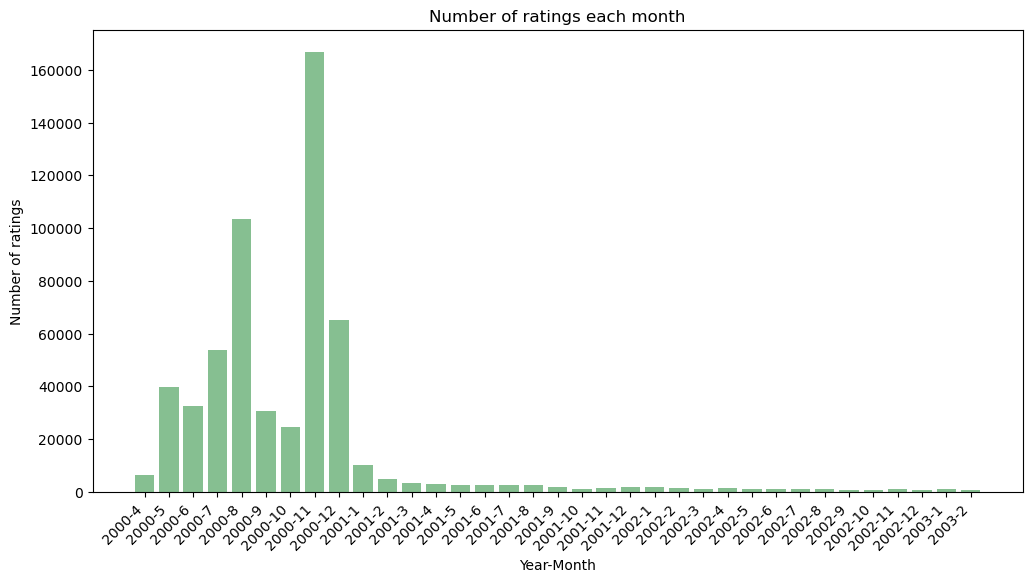

,user_id,movie_id,rating,timestamp,genres
0,5522,3524,4,960090138,Comedy|Romance
1,2761,3037,4,973149573,Comedy|Drama|Western
2,5514,3174,5,959708144,Comedy|Drama
3,1882,2871,5,974704258,Adventure|Thriller
4,1643,2648,5,1011843256,Horror


In [10]:
file_depth = '../..'

with open(file_depth + '/config/data_1m_config.json') as config_file:
    config = json.load(config_file)

movies_data_path = config['original_csv_movies_data']
ratings_data_path = config['original_csv_ratings_data']
users_data_path = config['original_csv_users_data']

movies = pd.read_csv(file_depth + movies_data_path)
ratings = pd.read_csv(file_depth + ratings_data_path)
users = pd.read_csv(file_depth + users_data_path)

# get all unique genres
unique_genres = movies['genres'].str.split('|', expand=True).stack().unique()

# ratings of 4 or 5
filtered_ratings = ratings[(ratings['rating'] == 4) | (ratings['rating'] == 5)]

final_ratings = filtered_ratings.merge(movies, on='movie_id', how='inner').drop(columns=['title', 'movie_year'])

print_graph(final_ratings)

# shuffle data and reset index 
final_ratings = shuffle(final_ratings)
final_ratings.reset_index(inplace=True, drop=True)

final_ratings.head()

--------

In [76]:
with open('rating_data_deviders/row_indexes.json') as row_indexes_file:
    row_indexes = json.load(row_indexes_file)

randomly shuffled ratings will be divided into 12 parts, in each in 48000 ratings


In [77]:
row_indexes

{'01': {'start': '0', 'end': '48000'},
 '02': {'start': '48001', 'end': '96000'},
 '03': {'start': '96001', 'end': '144000'},
 '04': {'start': '144001', 'end': '192000'},
 '05': {'start': '192001', 'end': '240000'},
 '06': {'start': '240001', 'end': '288000'},
 '07': {'start': '288001', 'end': '336000'},
 '08': {'start': '336001', 'end': '384000'},
 '09': {'start': '384001', 'end': '432000'},
 '10': {'start': '432001', 'end': '480000'},
 '11': {'start': '480001', 'end': '528000'},
 '12': {'start': '528001', 'end': '575281'}}

In [78]:
splits = []

for one_split in row_indexes:

    start_index = int(row_indexes[one_split]['start'])
    end_index = int(row_indexes[one_split]['end'])
    filtered_by_indexes = final_ratings.iloc[start_index:end_index]
    splits.append(filtered_by_indexes)

In [79]:
print(f"Number of splits: {len(splits)}")
print('------------------------------------')
count = 0
for i in range(len(splits)):
    print(f"Split {i + 1}: {len(splits[i])} rows")
    count += len(splits[i])

print('------------------------------------')

print(f"Total rows: {count}")

Number of splits: 12
------------------------------------
Split 1: 48000 rows
Split 2: 47999 rows
Split 3: 47999 rows
Split 4: 47999 rows
Split 5: 47999 rows
Split 6: 47999 rows
Split 7: 47999 rows
Split 8: 47999 rows
Split 9: 47999 rows
Split 10: 47999 rows
Split 11: 47999 rows
Split 12: 47280 rows
------------------------------------
Total rows: 575270


In [80]:
# save splits to csv files 
for index, split in enumerate(splits):
    split.to_csv(f"rating_user_data/splits/rating_split{index + 1}.csv", index=False)

In [81]:
def get_users_present_in_all_splits(splits):
    common_users = set(splits[0]['user_id'])

    for df in splits[1:]:
        current_users = set(df['user_id'])
        common_users = common_users.intersection(current_users)
        
    print(f"Number of users present in all splits: {len(common_users)}")
    print(f"Returning the first user_id in the list: {list(common_users)[0]}")
    return list(common_users)[0]

In [82]:
def create_set(split, unique_genres):
    
    user_vectors = {}
    grouped_split_data = split.groupby('user_id')

    for user_id, group in grouped_split_data:
        user_genre_vectors = {}
        
        for genre in unique_genres:
            split_genres = group['genres'].str.split('|')
            movies_in_genre_count = split_genres.apply(lambda x: genre in x).sum()
            user_genre_vectors[genre] = int(movies_in_genre_count)

        user_vectors[user_id] = user_genre_vectors
        
    return user_vectors

In [95]:
def get_similarity_from_sets(target_user_id, splits, unique_genres):

    similarities = []
    sets_of_categories_for_each_user = []

    for split in tqdm(splits):
        user_category_set = create_set(split, unique_genres)

        if target_user_id in user_category_set:
            target_user = list(user_category_set[target_user_id].values())
            one_set_similarities = {}

            for user_id, user_data in user_category_set.items():
                if user_id != target_user_id:  # Skip if it's the target user
                    user_x = list(user_data.values())
                    similarity = 1 - spatial.distance.cosine(target_user, user_x)
                    one_set_similarities[user_id] = similarity
        else:
            print(f"User with id {target_user_id} is not in user_category_set") 
            exit()
        

        sets_of_categories_for_each_user.append(user_category_set)
        similarities.append(one_set_similarities)
    
    return similarities, sets_of_categories_for_each_user

In [96]:
target_user_id = get_users_present_in_all_splits(splits)
similarities, sets = get_similarity_from_sets(target_user_id, splits, unique_genres)

Number of users present in all splits: 4084
Returning the first user_id in the list: 1


100%|██████████| 12/12 [07:30<00:00, 37.52s/it]


In [97]:
save_sets_of_categories_file = 'rating_user_data/sets_of_categories_for_each_user.json'
save_similarities_file = f"rating_user_data/similarities_to_user_{target_user_id}.json"


with open(save_sets_of_categories_file, 'w') as fp:
    json.dump(sets, fp)

with open(save_similarities_file, 'w') as fp:
    json.dump(similarities, fp)